In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import sys
import io

import matplotlib.gridspec as gridspec
from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb
from matplotlib import pyplot as plt

from skimage import color
from skimage.io import imread
from skimage.io import imshow
from scipy.sparse import csr_matrix

import torch
from torch import optim
from torch.nn import functional as tf
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from utils import VOC_LABEL2COLOR
from utils import VOC_STATISTICS
from utils import numpy2torch
from utils import torch2numpy

In [2]:
def color2label(gt_in_colors):
    # Transforming [H,W,C] label colors to [H,W] true labels
    def get_label_from_color(rgb):
        # Somehow imread() on a png file gives (x,y,4); We ignore the last entry which is always 255
        label_color = tuple([rgb[0], rgb[1], rgb[2]])
        # TODO: Make the lookup faster?
        if label_color in VOC_LABEL2COLOR:
            return VOC_LABEL2COLOR.index(label_color)
        else:
            return 0
    gt_labels = np.apply_along_axis(get_label_from_color, 2, gt_in_colors)
    return gt_labels

In [3]:
# VOC Dataset class, derived from PyTorch Dataset
class VOC2007Dataset(Dataset):
    def __init__(self, root, train, num_examples):
        super().__init__()
        
        # Reading num_examples lines from the split file for the image names
        if train:
            split_file = open(root + "/ImageSets/Segmentation/train.txt", "r")
        else:
            split_file = open(root + "/ImageSets/Segmentation/val.txt", "r")
        splits = []
        
        # TODO: Read random line?
        for _ in range(0, num_examples):
            line = split_file.readline()
            splits.append(line[:6])
        split_file.close()
                
        # Reading pictures and gt for the entries in splits
        # Saving a dictionary of {im, gt} for every entry in splits
        self.data = []
        c = 0
        for name in splits:
            print("{}/{}".format(c+1, len(splits)), end="\r", flush=True)
            self.data.append({
                "im": numpy2torch(imread(root + "/JPEGImages/{}.jpg".format(name))),
                # Colors in gt are converted to true labels
                "gt": numpy2torch(color2label(imread(root + "/SegmentationClass/{}.png".format(name))))
            })   
            c += 1    
    
    def __getitem__(self, index):
        # Returning random dictionary of {im, gt} from dataset
        example_dict = np.random.choice(self.data)
        assert (isinstance(example_dict, dict))
        assert ('im' in example_dict.keys())
        assert ('gt' in example_dict.keys())
        return example_dict

    def __len__(self):
        return len(self.data)

In [4]:
# Create and return pytorch.utils DataLoader
def create_loader(dataset, batch_size, shuffle, num_workers):
    loader = DataLoader(dataset, batch_size, shuffle, num_workers=num_workers)
    assert (isinstance(loader, DataLoader))
    return loader

In [5]:
"""
    Transforms RGB to HSV colorspace and adds label color.
    
    :param ndarray np_image: [H,W,C] integer numpy image
    :param ndaraay np_label: [H,W] numpy array of true labels
    :return : [H,W,C] numpy image 
"""
def voc_label2color(np_image, np_label):
    assert (isinstance(np_image, np.ndarray))
    assert (isinstance(np_label, np.ndarray))

    # Transform input into hsv space
    # np_image gets casted to float at division
    hsv_image = rgb_to_hsv(np_image/255.0)

    # Iterate over all pixels
    for x in range(0, np_label.shape[0]):
        for y in range(0, np_label.shape[1]):
            label_color = np.asarray(VOC_LABEL2COLOR[int(np_label[x, y])])
            hsv_label_color = rgb_to_hsv(label_color/255.0)
            hsv_image[x, y, 0] = hsv_label_color[0]
            hsv_image[x, y, 1] = hsv_label_color[1]
    
    colored = hsv_to_rgb(hsv_image)

    assert (np.equal(colored.shape, np_image.shape).all())
    # assert (np_image.dtype == colored.dtype)
    return colored

In [6]:
def show_dataset_examples(loader, grid_height, grid_width, title):
    fig = plt.figure()
    fig.suptitle(title)

    c = 1
    # Call the data loader until grid_height*grid_width samples are generated
    for dic in loader:
        if c > grid_height*grid_width:
            break
        else:
            ax = fig.add_subplot(grid_height, grid_width, c)
            colored_img = voc_label2color(torch2numpy(dic["im"][0, :, :, :]), torch2numpy(dic["gt"][0, :, :, :]))
            ax.imshow(colored_img)
            c += 1
    plt.show()
    pass

In [7]:
def standardize_input(input_tensor):
    
    # Normalize input by (x - mean(x)) / std(x) from VOC_STATISTICS
    normalized = torch.zeros(size=input_tensor.shape)
    
    """
    normalized[0,0,:,:] = (input_tensor[0,0,:,:] - VOC_STATISTICS["mean"][0]) / VOC_STATISTICS["std"][0]
    normalized[0,1,:,:] = (input_tensor[0,1,:,:] - VOC_STATISTICS["mean"][1]) / VOC_STATISTICS["std"][1]
    normalized[0,2,:,:] = (input_tensor[0,2,:,:] - VOC_STATISTICS["mean"][2]) / VOC_STATISTICS["std"][2]
    """
    transformation = transforms.Normalize(
        mean=VOC_STATISTICS["mean"],
        std=VOC_STATISTICS["std"]
    )
    
    normalized[0, :, :, :] = transformation(input_tensor[0, :, :, :].float())
    
    assert (type(input_tensor) == type(normalized))
    assert (input_tensor.size() == normalized.size())
    return normalized

In [8]:
"""
    Run model forward pass and return label prediction of input image.
    
    :param tensor normalized: [1, C, H, W] float pytorch tensor of input image
    :param model model: torchvision model used for inference
    :return : [1, 1, H, W] prediction of true labels; [1, 21, H, W] tensor of activation values
"""
def run_forward_pass(normalized, model):
    
    model.eval()
    
    # Activation function values: 21 x (height x width) tensors
    # containing the predicted unnormalized probabilites for the 21 labels for each pixel of the normalized input
    output = model(normalized)
    acts = output['out']
    
    # ---------- Do a 'softmax' on the 21 labels dimension ----------
    
    prediction = torch.zeros(size=(1, 1, normalized.shape[2], normalized.shape[3]))

    # Iterate over all pixels
    for x in range(0, normalized.shape[2]):
        for y in range(0,normalized.shape[3]):
            # Get label with max. probability:
            xy_label = torch.argmax(acts[0,:,x,y]).item()
            # Assign label color to prediction
            prediction[0,0,x,y] = xy_label            

    assert (isinstance(prediction, torch.Tensor))
    assert (isinstance(acts, torch.Tensor))
    
    # Torch variables requiring grad need to be detached 
    # casting prediction to integer values
    return prediction.detach(), acts.detach()

In [9]:
def average_precision(prediction, gt):
    assert (prediction.shape == gt.shape)
    assert (prediction.dtype == gt.dtype)
    sum_of_equal_elements = sum(sum((prediction == gt)))
    sum_of_elements = gt.numel()
    
    return float(sum_of_equal_elements) / float(sum_of_elements)

In [21]:
def show_inference_examples(loader, model, grid_height, grid_width, title):
        
    c = 1
    for dic in loader:
       
        if c > grid_height*grid_width:
            break
                
        # Normalize current image
        std_im = standardize_input(dic["im"])
        
        # Ground truth
        gt = dic["gt"].float()
        
        # Get label predictions for current image
        # TODO: Predictions seem to be very bad ...
        prediction, _ = run_forward_pass(std_im, model)
        
        # Get average precision
        avp = average_precision(prediction[0,0,:,:], gt[0,0,:,:])
        
        # Plot predictions and ground truth
        fig = plt.figure()
        prediction = voc_label2color(torch2numpy(dic["im"][0,:,:,:]), torch2numpy(prediction[0,:,:,:]))
        true = voc_label2color(torch2numpy(dic["im"][0,:,:,:]), torch2numpy(dic["gt"][0,:,:,:]))
        ax_pred = fig.add_subplot(1, 2, 1)
        ax_pred.imshow(prediction)
        ax_pred.set_title("Prediction")
        ax_true = fig.add_subplot(1, 2, 2)
        ax_true.imshow(true)
        ax_true.set_title("Ground truth")
        fig.suptitle("AVP: "+ str(round(avp,5)))
        
        c += 1
        fig.show()
    pass

In [11]:
def find_unique_example(loader, unique_foreground_label):
    example = []

    assert (isinstance(example, dict))
    return example

In [12]:
def show_unique_example(example_dict, model):
    pass

In [13]:
def show_attack(example_dict, model, src_label, target_label, learning_rate, iterations):
    pass

In [14]:
# Please set an environment variables 'VOC2007_HOME' pointing to your '../VOCdevkit/VOC2007' folder
os.environ["VOC2007_HOME"] = "/home/yannik/Computer-Vison-2/asgn4/VOCdevkit/VOC2007"
root = os.environ["VOC2007_HOME"]

In [15]:
# create datasets for training and validation
print("Creating datasets...")
#train_dataset = VOC2007Dataset(root, train=True, num_examples=128)
train_dataset = VOC2007Dataset(root, train=True, num_examples=16)
print("\n")
#valid_dataset = VOC2007Dataset(root, train=False, num_examples=128)
valid_dataset = VOC2007Dataset(root, train=False, num_examples=16)

Creating datasets...
16/16



In [16]:
# create data loaders for training and validation
# you can safely assume batch_size=1 in our tests..
print("Creating data loaders...")
train_loader = create_loader(train_dataset, batch_size=1, shuffle=True, num_workers=1)
valid_loader = create_loader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

Creating data loaders...


Dataset examples...


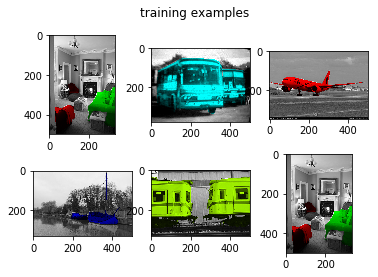

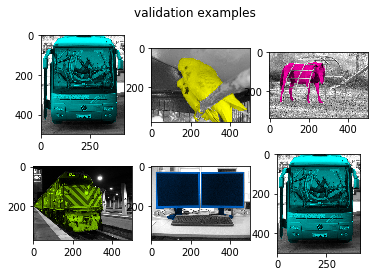

In [17]:
# show some images for the training and validation set
print("Dataset examples...")
show_dataset_examples(train_loader, grid_height=2, grid_width=3, title='training examples')
show_dataset_examples(valid_loader, grid_height=2, grid_width=3, title='validation examples')

In [22]:
# Load Deeplab network
print("Loading deeplab network model...")
model = models.segmentation.deeplabv3_resnet101(pretrained=True, num_classes=21)

# Apply deeplab. Switch to training loader if you want more variety.
print("\nInference with deeplab network model...")
show_inference_examples(valid_loader, model, grid_height=2, grid_width=3, title='inference examples')

del

Loading deeplab network model...

Inference with deeplab network model...


OSError: [Errno 12] Cannot allocate memory

In [19]:
"""
# attack1: convert cat to dog
cat_example = find_unique_example(valid_loader, unique_foreground_label=8)
show_unique_example(cat_example, model=model)
show_attack(cat_example, model, src_label=8, target_label=12, learning_rate=1.0, iterations=10)
"""

# feel free to try other examples..

'\n# attack1: convert cat to dog\ncat_example = find_unique_example(valid_loader, unique_foreground_label=8)\nshow_unique_example(cat_example, model=model)\nshow_attack(cat_example, model, src_label=8, target_label=12, learning_rate=1.0, iterations=10)\n'